In [ ]:
print("Running base classical head with disabled quantum circuit")

Running base classical head with disabled quantum circuit


In [ ]:
import pennylane as qml
import numpy as np
from math import ceil, log2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from schmidt_decomposition import SchmidtDecomposition


# -----------------------------------------------------------------------------
# 2) Quantum circuit module - FIXED TENSOR HANDLING
# -----------------------------------------------------------------------------
class SchmidtQuantumCircuit(nn.Module):
    def __init__(
        self,
        n_qubits: int,
        n_terms: int,
        init_terms: list = None,
        n_ancilla_layers: int = 2,
    ):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_terms = n_terms
        self.n_ancilla = ceil(log2(n_terms)) if n_terms > 1 else 0
        self.n_ancilla_layers = n_ancilla_layers

        # Ancilla rotation parameters
        if self.n_ancilla > 0:
            num_ancilla_params = self.n_ancilla + max(0, self.n_ancilla - 1)
            self.ancilla_params = nn.Parameter(
                torch.randn(self.n_ancilla_layers * num_ancilla_params)
            )
        else:
            self.ancilla_params = None

        # Data-qubit parameters - now with optional Schmidt initialization
        self.unitary_params = nn.ParameterList()

        # # Initialize from Schmidt decomposition if provided
        # # We did not observe any performance improvement from this!
        # # maybe the angle computations for also coefficients would make better!
        # if init_terms:

        #     for k in range(min(n_terms, len(init_terms))):
        #         term_angles = []
        #         for vector in init_terms[k]:
        #             angle = SchmidtDecomposition.vector_to_angle(vector)
        #             term_angles.append(angle)
        #         # Initialize parameter with Schmidt-derived angles
        #         self.unitary_params.append(
        #             nn.Parameter(torch.tensor(term_angles, dtype=torch.float32)))

        #     # Initialize remaining terms randomly
        #     for _ in range(n_terms - len(init_terms)):
        #         print("herrrrr")
        #         self.unitary_params.append(
        #             nn.Parameter(torch.randn(self.n_qubits)))
        # else:
        # All random initialization
        for _ in range(n_terms):
            self.unitary_params.append(nn.Parameter(torch.randn(self.n_qubits)))

        self.dev = qml.device("lightning.qubit", wires=self.n_ancilla + self.n_qubits)
        self.qnode = self.create_qnode()

    def create_qnode(self):
        @qml.qnode(self.dev, interface="torch")
        def circuit(features):
            # Ancilla preparation
            if self.n_ancilla > 0:
                p = 0
                for l in range(self.n_ancilla_layers):
                    for i in range(self.n_ancilla):
                        qml.RY(self.ancilla_params[p], wires=i)
                        p += 1
                    for i in range(self.n_ancilla - 1):
                        qml.CRY(self.ancilla_params[p], wires=[i, i + 1])
                        p += 1

            # Embed input data
            data_wires = list(range(self.n_ancilla, self.n_ancilla + self.n_qubits))
            qml.AmplitudeEmbedding(features=features, wires=data_wires, normalize=True)

            # Apply parameterized unitaries
            ctrl_qubits = list(range(self.n_ancilla))
            if self.n_ancilla == 0:
                for q in range(self.n_qubits):
                    qml.RY(self.unitary_params[0][q], wires=q + self.n_ancilla)
            else:
                for k in range(self.n_terms):
                    ctrl_bin_values = bin(k)[2:].zfill(self.n_ancilla)
                    ctrl_int_values = [int(a) for a in list(ctrl_bin_values)]
                    for q in range(self.n_qubits):
                        qml.ctrl(qml.RY, ctrl_qubits, control_values=ctrl_int_values)(
                            self.unitary_params[k][q], wires=q + self.n_ancilla
                        )

            return [qml.expval(qml.PauliZ(w)) for w in data_wires]

        return circuit

    def forward(self, x: torch.Tensor):
        # x: [batch, features]
        # Process each sample individually
        
        return x.float()
        results = []
        for sample in x:
            results.append(torch.Tensor(self.qnode(sample)).float())
        return torch.stack(results)


# -----------------------------------------------------------------------------
# 3) Hybrid classifier
# -----------------------------------------------------------------------------
class HybridModel(nn.Module):
    def __init__(
        self,
        n_qubits: int,
        data_mean: np.ndarray,
        output_dim: int = 1,
        schmidt_threshold: float = 0.1,
        hidden_dims=[64, 32],
        dropout_prob=0.25,
        min_terms=1 #min schmidt terms, min ancilla
    ):
        super().__init__()
        # Schmidt decomposition on the mean
        sd = SchmidtDecomposition(threshold=schmidt_threshold)
        terms, _ = sd.flatten_decomposition(data_mean)
        n_terms = len(terms)
        if n_terms == 1:
            n_terms = min_terms
        self.qc = SchmidtQuantumCircuit(n_qubits, n_terms, terms)
        total_wires = n_qubits + self.qc.n_ancilla
        print(
            f"number of schmidt terms: {n_terms},"
            f"number of ancilla qubits:{self.qc.n_ancilla}"
        )

        # classical head takes exactly n_qubits inputs
        layers = []
        input_dim = 2**n_qubits
        for h in hidden_dims:
            layers += [
                nn.Linear(input_dim, h),
                nn.BatchNorm1d(h),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
            ]
            input_dim = h

        # final classifier
        layers.append(nn.Linear(input_dim, output_dim))
        self.classical_net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor):
        # x: [batch, features]
        q_out = self.qc(x)
        return self.classical_net(q_out)


# -----------------------------------------------------------------------------
# K-Fold cross-validation driver
# -----------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, train_test_split


def cross_validate(
    X,
    y,
    n_qubits,
    n_classes,
    schmidt_threshold=0.1,
    hidden_dims=[64,32],
    max_terms=4, #not used
    min_terms=1,
    epochs=50,
    lr=0.05,
    batch_size=32,
    k_folds=5,
    val_frac=0.2,
    dataset_name="",
    seed=42,
):
    # reproducibility & device
    torch.manual_seed(seed)
    np.random.seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=seed)
    fold_accuracies = []
    losses = {}
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== Dataset={dataset_name} | Fold {fold}/{k_folds} ===")

        # Split out test fold
        X_train_full, y_train_full = X[train_idx], y[train_idx]
        X_test, y_test = X[test_idx], y[test_idx]

        # Further carve out a validation set from the training folds
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full,
            y_train_full,
            test_size=val_frac,
            random_state=seed+fold,
            stratify=y_train_full,
        )

        # DataLoaders
        train_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_train, dtype=torch.float64),
                torch.tensor(y_train, dtype=torch.long),
            ),
            batch_size=batch_size,
            shuffle=True,
        )
        val_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_val, dtype=torch.float64),
                torch.tensor(y_val, dtype=torch.long),
            ),
            batch_size=batch_size,
        )
        test_loader = DataLoader(
            TensorDataset(
                torch.tensor(X_test, dtype=torch.float64),
                torch.tensor(y_test, dtype=torch.long),
            ),
            batch_size=batch_size,
        )

        # Precompute mean vector for Schmidt decomposition
        mean_vec = X_train.mean(axis=0)
        mean_vec /= np.linalg.norm(mean_vec)
        
        # Initialize model, optimizer, scheduler, loss
        model = HybridModel(
            n_qubits,
            mean_vec,
            output_dim=n_classes,
            schmidt_threshold=schmidt_threshold,
            hidden_dims=hidden_dims,
            min_terms=min_terms,
        )
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
        loss_fn = nn.CrossEntropyLoss()
        print(f"Using {device} for training")
        print(f"Model: {model}")
        print(
            f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
        )
        print(f"Optimizer: {opt}")
        print(f"Loss Function: {loss_fn}")
        best_val_acc = 0.0
        best_state = None
        losses[fold] = []
        # ----- Training Loop -----
        for ep in range(1, epochs + 1):
            model.train()
            running_loss = 0.0
            correct, total = 0, 0

            for xb, yb in train_loader:
                opt.zero_grad()
                preds = model(xb)
 
                loss = loss_fn(preds, yb)
                loss.backward()
                opt.step()

                running_loss += loss.item() * xb.size(0)
                correct += (preds.argmax(1) == yb).sum().item()
                total += xb.size(0)

            sched.step()
            train_acc = correct / total

            # ----- Validation -----
            model.eval()
            v_corr, v_tot = 0, 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    preds = model(xb)
                    v_corr += (preds.argmax(1) == yb).sum().item()
                    v_tot += xb.size(0)
            val_acc = v_corr / v_tot

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = model.state_dict()

            if ep % 10 == 0 or ep == 1:
                lr_val = sched.get_last_lr()[0]
                print(
                    f" Ep{ep:2d}  loss={(running_loss/total):.4f}  "
                    f"train_acc={train_acc:.3f}  val_acc={val_acc:.3f}  lr={lr_val:.6f}"
                )
            losses[fold].append([(running_loss / total), train_acc, val_acc])
        # ----- Test Evaluation -----
        model.load_state_dict(best_state)
        model.eval()
        t_corr, t_tot = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                preds = model(xb)
                t_corr += (preds.argmax(1) == yb).sum().item()
                t_tot += xb.size(0)
        test_acc = t_corr / t_tot

        print(f" >>> Fold {fold} Test Accuracy: {test_acc:.3f}")
        fold_accuracies.append(test_acc)

    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    print(f"\n>>> {dataset_name} CV Results: mean={mean_acc:.3f}, std={std_acc:.3f}\n")
    return fold_accuracies, losses


# if __name__ == "__main__":
from data_loaders import load_dataset

datasets = [
    "iris",
    "wine",
    "breast_cancer",
    "ionosphere",
    "covtype",
    "digits",
]
all_results = {}
all_losses = {}
for ds in datasets:
    X, y, n_qubits, n_classes = load_dataset(ds)

    print(f"\n=== Dataset={ds}")
    accs, losses = cross_validate(
        X,
        y,
        n_qubits,
        n_classes,
        hidden_dims=[64,32],
        schmidt_threshold=0.3,
        min_terms=1,
        epochs=200,
        lr=0.05,
        batch_size=32,
        k_folds=5,
        val_frac=0.2,
        seed=42,
        dataset_name=ds,
    )
    all_results[ds] = accs
    all_losses[ds] = losses
    print("=" * 40)
    print("=" * 40)
# Summary
print("=== Final Summary ===")
for ds, accs in all_results.items():
    print(
        f"{ds:15} folds={len(accs)}  mean_acc={np.mean(accs):.3f}  std={np.std(accs):.3f}"
    )


=== Dataset=iris

=== Dataset=iris | Fold 1/5 ===
number of schmidt terms: 1,number of ancilla qubits:0
Using cpu for training
Model: HybridModel(
  (qc): SchmidtQuantumCircuit(
    (unitary_params): ParameterList(  (0): Parameter containing: [torch.float32 of size 2])
  )
  (classical_net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=32, out_features=3, bias=True)
  )
)
Number of parameters: 2693
Optimizer: AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None

In [ ]:
def plot_cv_results(all_results, all_losses, fig_name="cv_results_summary"):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.ticker import MaxNLocator
    from matplotlib.lines import Line2D
    import seaborn as sns
    
    # Configure global font settings
    mpl.rcParams.update({
        'font.size': 24,
        'axes.titlesize': 24,
        'axes.labelsize': 24,
        'xtick.labelsize': 24,
        'ytick.labelsize': 24,
        'legend.fontsize': 24
    })
    
    # Create 2x3 grid
    fig, axs = plt.subplots(2, 3, figsize=(24, 16))
    axs = axs.flatten()
    
    palette = sns.color_palette("pastel")
    loss_color = palette[0]       
    train_acc_color = palette[1]  
    val_acc_color = palette[6]    
    
    # Create custom legend elements
    legend_elements = [
        Line2D([0], [0], color=loss_color, lw=3, label='Train Loss'),
        Line2D([0], [0], color=train_acc_color, lw=3, label='Train Accuracy'),
        Line2D([0], [0], color=val_acc_color, lw=3, label='Validation Accuracy')
    ]
    
    for i, (dataset, fold_losses) in enumerate(all_losses.items()):
        if i >= 6:  # Only plot first 6 datasets
            break
            
        ax = axs[i]
        n_folds = len(fold_losses)
        max_epochs = max(len(fold) for fold in fold_losses.values())
        
        # Prepare arrays for metrics
        train_loss = np.full((n_folds, max_epochs), np.nan)
        train_acc = np.full((n_folds, max_epochs), np.nan)
        val_acc = np.full((n_folds, max_epochs), np.nan)
        best_val_acc = np.zeros(n_folds)
        
        # Extract metrics for each fold
        for fold_idx, fold_data in enumerate(fold_losses.values()):
            n_epochs = len(fold_data)
            train_loss[fold_idx, :n_epochs] = [x[0] for x in fold_data]
            train_acc[fold_idx, :n_epochs] = [x[1] for x in fold_data]
            val_acc[fold_idx, :n_epochs] = [x[2] for x in fold_data]
            best_val_acc[fold_idx] = max(x[2] for x in fold_data)
        
        # Calculate means and stds
        mean_train_loss = np.nanmean(train_loss, axis=0)
        mean_train_acc = np.nanmean(train_acc, axis=0)
        mean_val_acc = np.nanmean(val_acc, axis=0)
        
        # Get test accuracies
        test_accs = all_results[dataset]
        mean_test_acc = np.mean(test_accs)
        std_test_acc = np.std(test_accs)
        # Create twin axis for accuracies
        ax2 = ax#.twinx()
        # Plot individual runs with shadows
        for fold_idx in range(n_folds):
            # Plot individual training loss (light shadow)
            ax.plot(train_loss[fold_idx], 
                     color=loss_color, 
                     alpha=0.35, 
                     linewidth=0.8)
            

            
            # Plot individual accuracy runs
            ax2.plot(train_acc[fold_idx], 
                      color=train_acc_color, 
                      alpha=0.35, 
                      linewidth=0.8)
            ax2.plot(val_acc[fold_idx], 
                      color=val_acc_color, 
                      alpha=0.35, 
                      linewidth=0.8)
        
        # Plot mean training loss
        ax.plot(mean_train_loss, color=loss_color, linewidth=3, alpha=1)
        
        # Plot mean accuracies
        ax2.plot(mean_train_acc, color=train_acc_color, linewidth=3, alpha=1)
        ax2.plot(mean_val_acc, color=val_acc_color, linewidth=3, alpha=1)
        
        
        # Set titles and labels
        title = f"{dataset.replace('_', ' ').title()}\n"
        title += f"Test Acc: {mean_test_acc:.3f} ± {std_test_acc:.3f}"
        ax.set_title(title, fontsize=24, pad=15)
        
        ax.set_xlabel('Epochs', fontsize=24)
        # ax.set_ylabel('Training Loss', fontsize=24)
        ax.set_ylabel('Loss / Accuracy', fontsize=24)
        
        # Set axis colors
        # ax.tick_params(axis='y', labelcolor=loss_color)
        # ax2.tick_params(axis='y', labelcolor=val_acc_color)
        
        # Configure grid and limits
        ax.grid(True, linestyle='--', alpha=0.3, axis='x')
        ax2.grid(True, linestyle='--', alpha=0.3, axis='y')
        
        ax.set_ylim(bottom=0)
        # ax2.set_ylim(0, 1.05)
        

    # Add common legend
    fig.legend(handles=legend_elements, loc='center', 
               ncol=4, fontsize=24, framealpha=0.9)
    
    # Adjust layout
    plt.tight_layout(pad=4.0, w_pad=3.0, h_pad=4.0)
    fig.subplots_adjust(bottom=0.1)  # Make space for legend
    
    # Save high-resolution figures
    plt.savefig(f'{fig_name}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'{fig_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

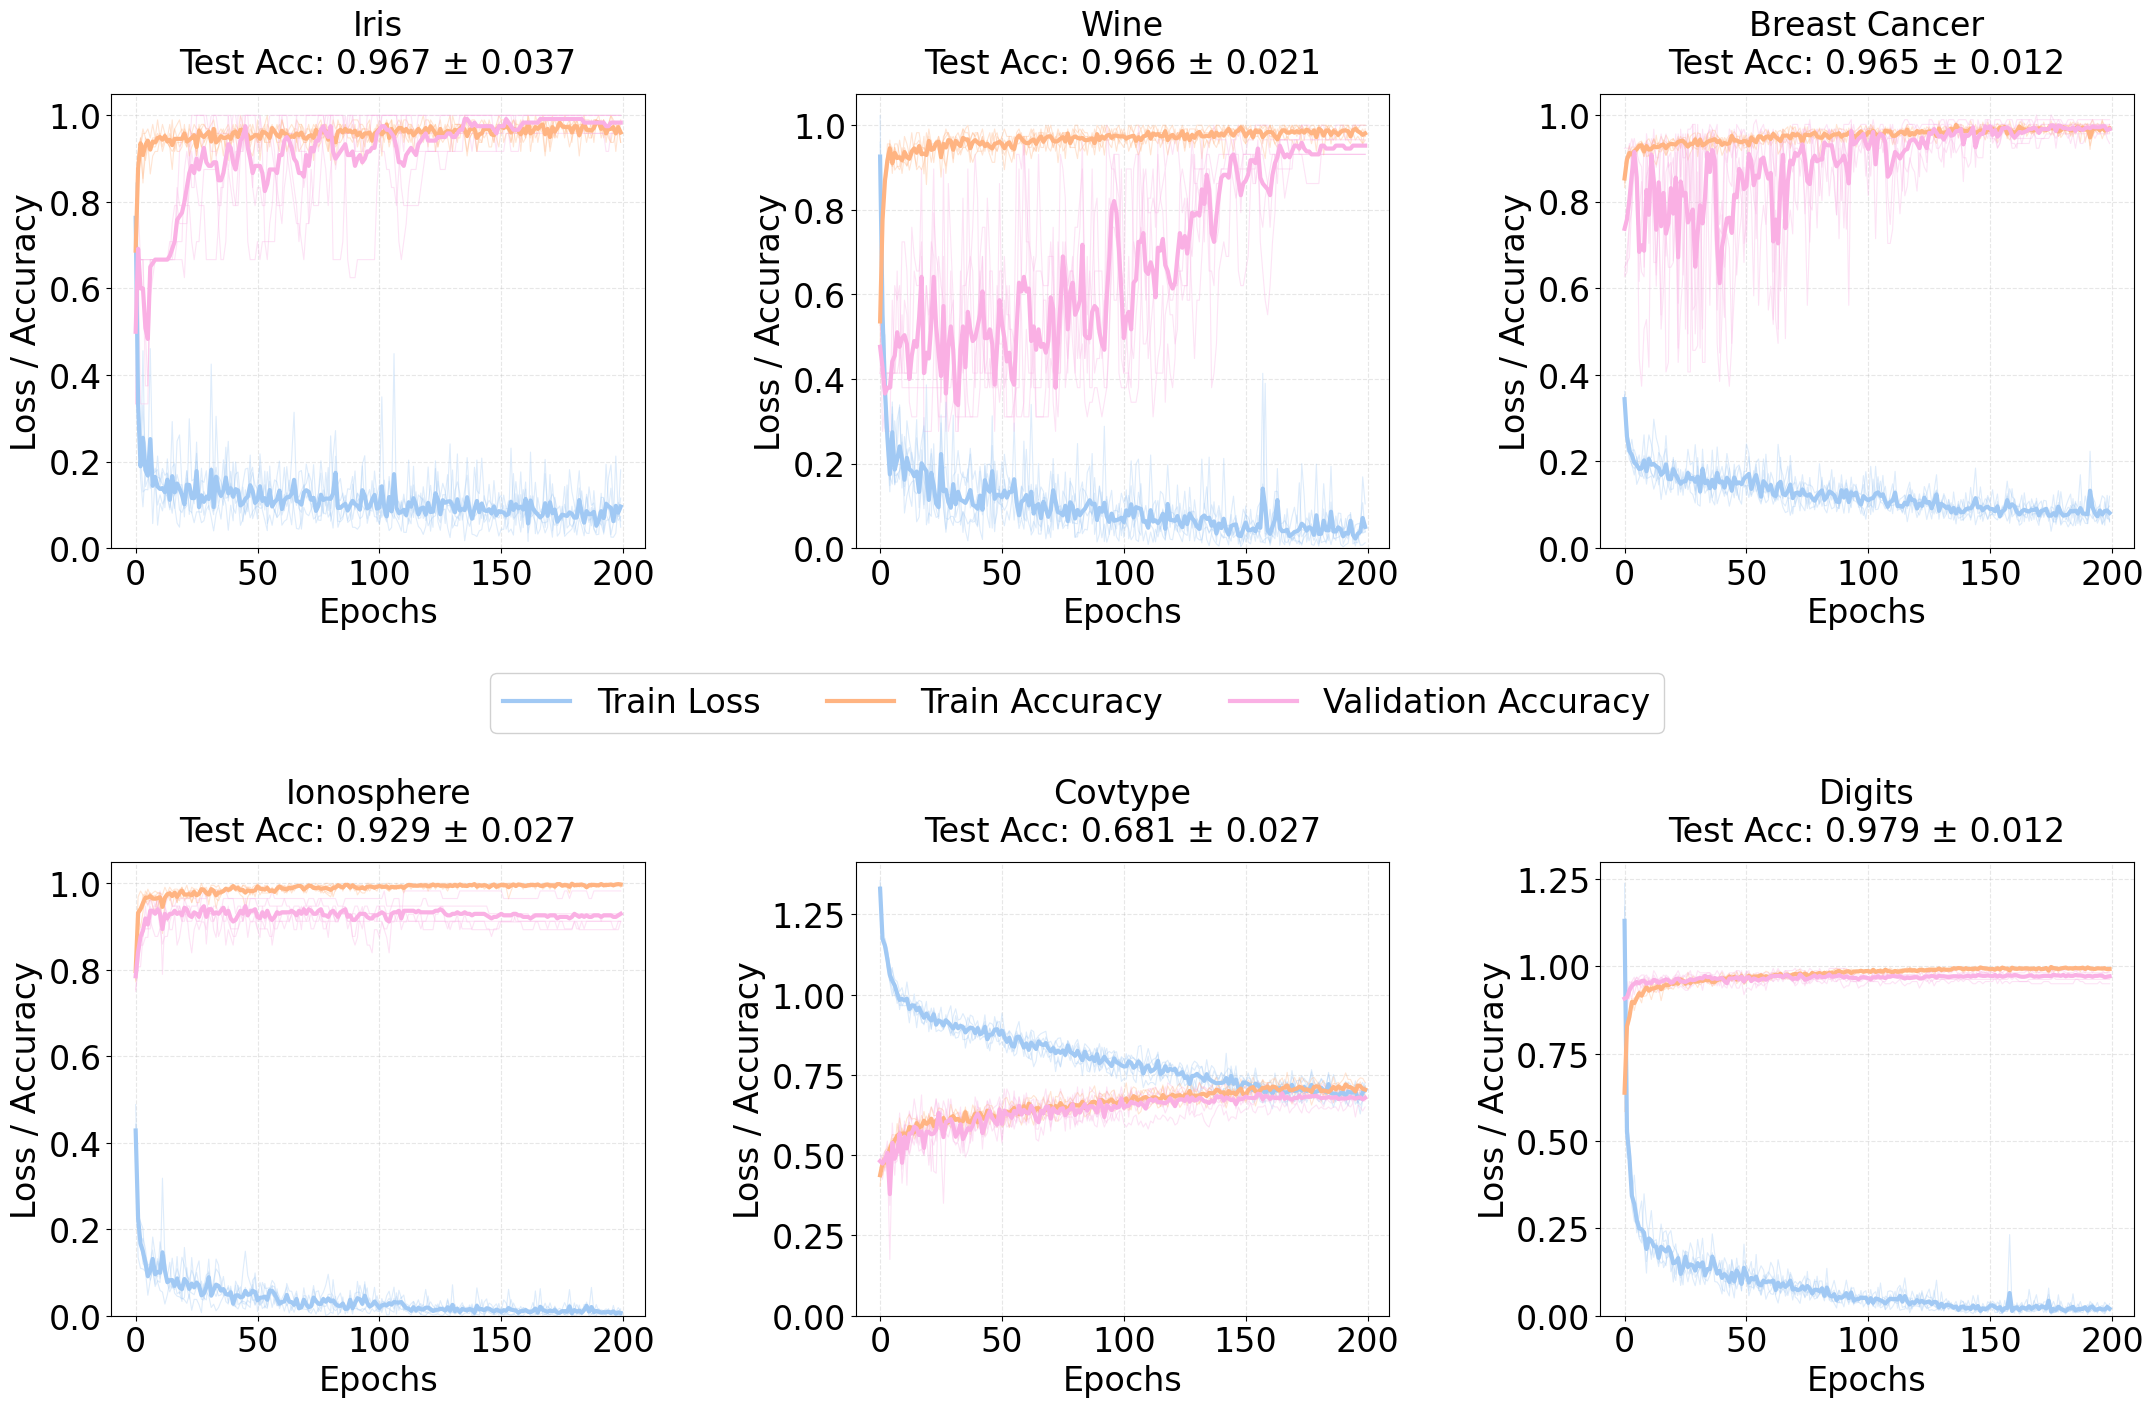

In [ ]:
plot_cv_results(all_results, all_losses, fig_name="fig_cross_validation_summary_classical")